# ResNet Results with Improved Figures (used in paper)



## Runtime

We recommend choosing a Deepmind CPU borg runtime for running this notebook.

### Imports

In [ ]:
#@title Load Imports { display-mode: "form" }
#@markdown This colab uses form cells. You can double-click any form cell to reveal the code underneath or edit it.
from colabtools import adhoc_import
import getpass
import pandas as pd
import numpy as onp
import pprint
import dataclasses
import jax
import jax.numpy as jnp
import json
import time
import re

import matplotlib.pyplot as plt
import seaborn
from absl import flags
FLAGS = flags.FLAGS
from google3.pyglib.contrib.gpathlib import gpath

#@markdown Specify client_name if you would like to use code in your citc client. If left blank, will use google3 at HEAD.
citc_client_name = '' #@param {type:'string'}

if citc_client_name:
  user_name = getpass.getuser()
  with adhoc_import.Google3CitcClient(citc_client_name, user_name):
    from google3.third_party.google_research.google_research.aqt import report_utils
    from google3.third_party.google_research.google_research.aqt import analysis_utils
    from google3.third_party.google_research.google_research.aqt import pandas_utils

    from google3.googlex.positron.tensorflow.jax.shared_utils import compute_cost_utils
    from google3.googlex.positron.tensorflow.jax.shared_utils import hlo_utils
    from google3.googlex.positron.tensorflow.jax.shared_utils import hparams_utils
    from google3.googlex.positron.tensorflow.jax.imagenet import hparams_config
    from google3.third_party.google_research.google_research.aqt import report_utils
    from google3.googlex.positron.tensorflow.jax.imagenet import models
    from google3.googlex.positron.tensorflow.jax.imagenet.train import create_model
    from google3.pyglib import resources
    from google3.pyglib import gfile
    from google3.pyglib.concurrent import parallel
else:
  with adhoc_import.Google3():
    from google3.third_party.google_research.google_research.aqt import report_utils
    from google3.third_party.google_research.google_research.aqt import analysis_utils
    from google3.third_party.google_research.google_research.aqt import pandas_utils

# matplotlib formatting
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'normal'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 22

# Pandas dataframe formatting
pd.set_option('max_colwidth', 50)
pd.options.display.float_format = "{:,.4f}".format

## Load Reports

In [ ]:
#@title Load all reports from CNS report directory { display-mode: "form" }
#@markdown Specify the directory where your reports are stored
report_dir = '/cns/tp-d/home/cerebra-catalyst/exp_reports/imagenet/' #@param {type:'string'}
report_dir = gpath.GPath(report_dir)
reports = report_utils.load_all_reports(report_dir, num_threads=100)

time to load reports: 6.791660785675049
Number of reports loaded: 197


### Convert reports to pandas dataframe

In [ ]:

import tree
def flatten_with_joined_string_paths(
    dictionary):
  """Flattens nested dict to single level dict with joined paths as keys."""
  flattened = tree.flatten_with_path(structure=dictionary)
  flattened_dict = {}
  # join path tuples to single string
  for path_tuple, val in flattened:
    # convert all path elements to strings
    path = [str(s) for s in path_tuple]
    path = '/'.join(path)
    flattened_dict[path] = val
  return flattened_dict


def convert_report_to_flat_dict_default(
    report):
  """Selects subset of report and flattens it to a single level dict.

  This function selects all information except what's stored under the fields
  `report_query_args` and `metadata_corp`.

  This function serves as an example for how to parse an ExperimentReport
  into a dataframe row by flattening it to a row_dict, with keys corresponding
  to dataframe columns.

  The ExperimentReport dataclass likely contains more information then you need
  for your analysis, so you can write your own function to pick and choose the
  information you want. You can refer to report_utils.ExperimentReport for
  documentation of all available fields.

  You can pass your custom function into convert_reports_to_dataframe().

  Args:
    report: An instance of ExperimentReport.

  Returns:
    A flattened dict representing a dataframe row.
  """

  row_dict = {}

  # Add smoothed metrics if present
  if report.metrics is not None:
    flattened_metrics = dict(flatten_with_joined_string_paths(report.metrics))
    # merge dicts
    row_dict = {**row_dict, **flattened_metrics}

  # Add unsmoothed metrics if present
  if report.unsmoothed_metrics is not None:
    flattened_unsmoothed_metrics = dict(
        flatten_with_joined_string_paths(report.unsmoothed_metrics))
    flattened_unsmoothed_metrics = {
        f'unsmoothed/{k}': v for k, v in flattened_unsmoothed_metrics.items()
    }
    # merge dicts
    row_dict = {**row_dict, **flattened_unsmoothed_metrics}

  # BEGIN GOOGLE-INTERNAL
  # Add XManager ID
  row_dict['xid'] = report.metadata_corp.xid

  # Add compute / memory cost information if present
  if report.compute_memory_cost is not None:
    row_dict['compute_cost'] = int(report.compute_memory_cost['compute_cost'])
    row_dict['memory_cost'] = int(report.compute_memory_cost['memory_cost'])
    if 'compute_cost_linear' in report.compute_memory_cost:
      row_dict['compute_cost_linear'] = int(report.compute_memory_cost['compute_cost_linear'])
  # END GOOGLE-INTERNAL

  # Ignore following fields because they have already been added, or we chose
  # not to include them.
  report_fields_to_ignore = {
      'metrics',
      'unsmoothed_metrics',
      # BEGIN GOOGLE-INTERNAL
      'metadata_corp',
      'compute_memory_cost'
      # END GOOGLE-INTERNAL
  }
  # Add other report fields.
  for field in dataclasses.fields(report):
    if field.name not in report_fields_to_ignore:
      row_dict[field.name] = getattr(report, field.name)

  return row_dict

In [ ]:
# using default converter

df = analysis_utils.convert_reports_to_dataframe(reports,convert_report_to_flat_dict_default )
print(df.shape)

(197, 25)


In [ ]:
df = pandas_utils.apply_filter_drop_rename_operations(
    df,
    row_filter_args=
      [('xid', [21226685,21374815,21374989,21374842])],
    row_regex_filter_args=
      [],
    rename_row_value_args=
      [('experiment_name', 'bf6', 'bf16'),
       ('experiment_name', 'imagenet_4b_wa_8bfirst_momax_dim_sweep', 'imagenet_4b_wa_8b_first_4b_last_momax_dim_sweep'),
       ('experiment_name', 'momax_', ''),
       ],
    drop_columns_by_regex_args=['.*unsmoothed.*', 'report_query_args', 'first_nan_step', 'num_train_steps', 'user_name'],
    rename_column_name_args=[('_translate--de-en:test', '')],
    sort_by_args=[('experiment_name', True),
                  ('compute_cost', True)],
  )

/google_src/head/depot/google3/third_party/google_research/google_research/aqt/pandas_utils.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda x: re.sub(pattern=pattern, repl=repl, string=x))


In [ ]:
df

,all/eval_accuracy,all/eval_loss,all/train_accuracy,all/train_learning_rate,all/train_loss,xid,model_dir,early_stop_step,experiment_name,launch_time,eval_freq,tensorboard_id,hparams_config_path,compute_cost,memory_cost,compute_cost_linear
0,0.7243,1.0943,0.7040,0.0001,1.2581,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"18,037,997,568.0000","27,599,616.0000","4,509,499,392.0000"
1,0.7411,1.0140,0.7354,0.0001,1.1141,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"26,252,858,224.0000","40,972,936.0000","6,563,214,556.0000"
2,0.7518,0.9614,0.7644,0.0001,0.9859,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"37,827,575,808.0000","58,949,376.0000","9,456,893,952.0000"
3,0.7596,0.9366,0.7842,0.0001,0.8991,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"49,670,161,264.0000","77,861,896.0000","12,417,540,316.0000"
4,0.7646,0.9170,0.8032,0.0001,0.8191,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"65,426,948,096.0000","102,011,648.0000","16,356,737,024.0000"
5,0.7720,0.8993,0.8317,0.0001,0.7006,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"100,836,114,432.0000","156,786,432.0000","25,209,028,608.0000"
6,0.7734,0.9037,0.8539,0.0001,0.6105,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"144,055,074,816.0000","223,273,728.0000","36,013,768,704.0000"
7,0.7725,0.9171,0.8632,0.0031,0.5728,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,31355,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"195,083,829,248.0000","301,473,536.0000","48,770,957,312.0000"
8,0.7740,0.9271,0.8794,0.0024,0.5083,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,33071,imagenet_4b_wa_4bfirstlast_dim_sweep,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"253,922,377,728.0000","391,385,856.0000","63,480,594,432.0000"
9,0.7321,1.0573,0.7173,0.0001,1.1946,21374815,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet...,38999,imagenet_4b_wa_8bfirstlast_dim_sweep,20210227T044418,156,3263796684541827212,/cns/tp-d/home/cerebra-catalyst/exp_reports/im...,"23,751,819,264.0000","31,733,248.0000","4,985,651,200.0000"


### Choose the experiment rows you want to analyze

In [ ]:
bf16_quad_cost = 1046831169536
bf16_linear_cost = 65426948096
bf16_memory_cost = 408046592
df['compute_cost_ratio_to_bf16_baseline_quadr'] = df['compute_cost']/bf16_quad_cost
df['compute_cost_ratio_to_bf16_baseline_linear'] = df['compute_cost_linear']/bf16_linear_cost
df['memory_cost_ratio_to_bf16_baseline'] = df['memory_cost']/bf16_memory_cost

## Rename experiments, mark baselines in each sweep
all "baseline" models have the original weight dimensions. (no architecture change, same # parameters)

## Results Table

In [ ]:
def extract_params(name):
  m=re.search(r'filter_multiplier=(\d+(\.\d+)?)', name)
  return pd.Series(dict(filter_multiplier=float(m[1])))
df=df.join(df.model_dir.apply(extract_params))

def extract_params(name):
  m=re.search(r'/(\d+)-', name)
  return pd.Series(dict(wid=int(m[1])))
df=df.join(df.model_dir.apply(extract_params))

first_col = df.pop('filter_multiplier')
df.insert(0, 'filter_multiplier', first_col)
first_col = df.pop('experiment_name')
df.insert(0, 'experiment_name', first_col)

In [ ]:
df = df[df['filter_multiplier'] != 2.5]
df = df[df['filter_multiplier'] != 0.37]

### After selecting the rows you want to analyize, reset index so index starts at 0.


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
#@title Example: Compare configs via file diffs by adding a diff link column { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment names etc.

#@markdown Choose the row index of the model to generate config diff links against (The index is in the left-most column)

#@markdown In this example, we choose to compare against bfloat16 config, since that's our baseline model.
diff_base_row_index =  19#@param {type: 'integer'}
if 'hparams_config_path' in list(df.columns):
  diff_config_path = df.loc[diff_base_row_index, 'hparams_config_path']
  # Create a new column that will contain the diff link for the experiment in that row
  df['config_diff_link'] = df.apply(lambda row: analysis_utils.generate_diff_link(diff_config_path, row['hparams_config_path']), axis=1)
else:
  print('hparams_config_path column not found in dataframe.')

Opening the link on in the config_diff_link column will now show you a line-by-line diff between the config of the experiment in that row vs. the diff base config you specified.

To open in a new tab, right-click the link. It should be a link like [example_diff_link](https://ocean-diff-viewer.corp.google.com/text?lhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fwmt_mlperf%2Fcns--tp-d--home--wanglisa--flax_wmt--leaderboard_full_model_bfloat16_wanglisa-20201201T185750--1-hparams_config_filename=leaderboard-full_model_bfloat16_seed1%2Fhparams_config.json&rhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fwmt_mlperf%2Fcns--tp-d--home--wanglisa--flax_wmt--leaderboard_full_model_4bit_weights_and_auto_acts_wanglisa-20201201T185750--1-hparams_config_filename=leaderboard-full_model_4bit_weights_and_auto_acts_seed1%2Fhparams_config.json)

In [ ]:
# use .format() and analysis_utils.clickable_link() to make the link text clickable.
pd.set_option('max_colwidth', -1)
df.style.format({'config_diff_link': analysis_utils.clickable_link})

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_wanglisa.kernel.wanglisa.406534833627.14b334fb3717c109/mount/server/dm_notebook3.par:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,experiment_name,filter_multiplier,all/eval_accuracy,all/eval_loss,all/train_accuracy,all/train_learning_rate,all/train_loss,xid,model_dir,early_stop_step,launch_time,eval_freq,tensorboard_id,hparams_config_path,compute_cost,memory_cost,compute_cost_linear,compute_cost_ratio_to_bf16_baseline_quadr,compute_cost_ratio_to_bf16_baseline_linear,memory_cost_ratio_to_bf16_baseline,wid,config_diff_link
0,imagenet_4b_wa_4bfirstlast_dim_sweep,0.500000,0.724291,1.094314,0.703980,0.000054,1.258104,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847/1-hparams_config_dict.model_hparams.filter_multiplier=0.5,38999,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/imagenet/cns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--1-hparams_config_dict.model_hparams.filter_multiplier=0/hparams_config.json,18037997568.000000,27599616.000000,4509499392.000000,0.017231,0.068924,0.067638,1,"<a href=""https://ocean-diff-viewer.corp.google.com/text?lhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_8b_wa_momax_dim_sweep_20210227_044427--2-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json&rhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--1-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json"">link"
1,imagenet_4b_wa_4bfirstlast_dim_sweep,0.620000,0.741102,1.013989,0.735446,0.000054,1.114093,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847/2-hparams_config_dict.model_hparams.filter_multiplier=0.62,38999,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/imagenet/cns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--2-hparams_config_dict.model_hparams.filter_multiplier=0/hparams_config.json,26252858224.000000,40972936.000000,6563214556.000000,0.025078,0.100314,0.100412,2,"<a href=""https://ocean-diff-viewer.corp.google.com/text?lhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_8b_wa_momax_dim_sweep_20210227_044427--2-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json&rhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--2-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json"">link"
2,imagenet_4b_wa_4bfirstlast_dim_sweep,0.750000,0.751840,0.961432,0.764430,0.000054,0.985929,21374842,/cns/tp-d/home/wanglisa/flax_imagenet/imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847/3-hparams_config_dict.model_hparams.filter_multiplier=0.75,38999,20210227T044915,156,8589197851733168309,/cns/tp-d/home/cerebra-catalyst/exp_reports/imagenet/cns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--3-hparams_config_dict.model_hparams.filter_multiplier=0/hparams_config.json,37827575808.000000,58949376.000000,9456893952.000000,0.036135,0.144541,0.144467,3,"<a href=""https://ocean-diff-viewer.corp.google.com/text?lhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_8b_wa_momax_dim_sweep_20210227_044427--2-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json&rhs=%2Fcns%2Ftp-d%2Fhome%2Fcerebra-catalyst%2Fexp_reports%2Fimagenet%2Fcns--tp-d--home--wanglisa--flax_imagenet--imagenet_4b_wa_4bfirstlast_momax_dim_sweep_20210227_044847--3-hparams_config_dict.model_hparams.filter_multiplier=0%2Fhparams_config.json"">link"
3,imagenet_4b_wa_4bfirstlast_dim_sweep,0.870000,0.759583,0.936561,0.784213,0.000054,

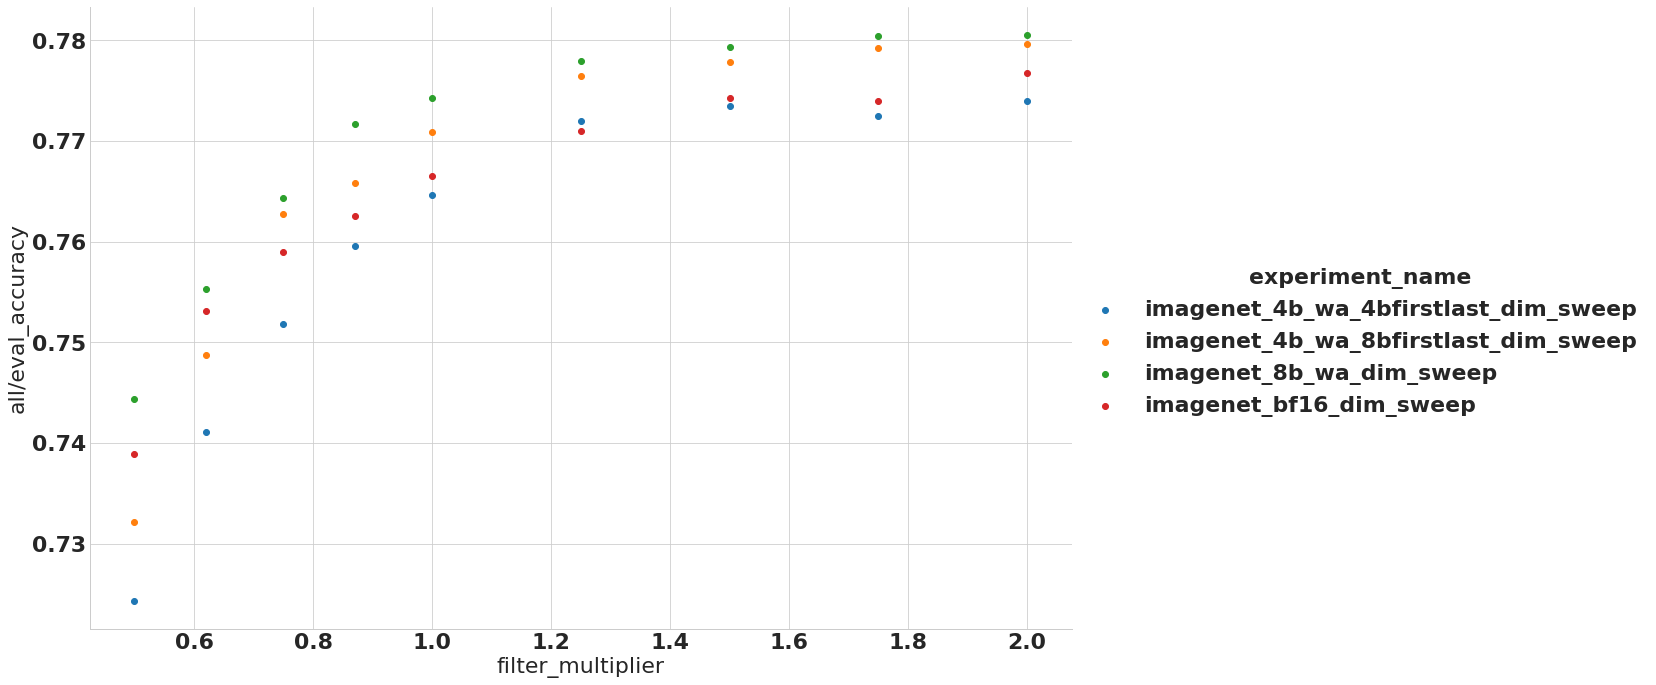

In [ ]:
#@title Example: Visualize two metric columns as a scatter plot with seaborn { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'filter_multiplier' #@param {type: 'string'}
column_for_y_axis = 'all/eval_accuracy' #@param {type: 'string'}

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.scatter, column_for_x_axis, column_for_y_axis).add_legend()


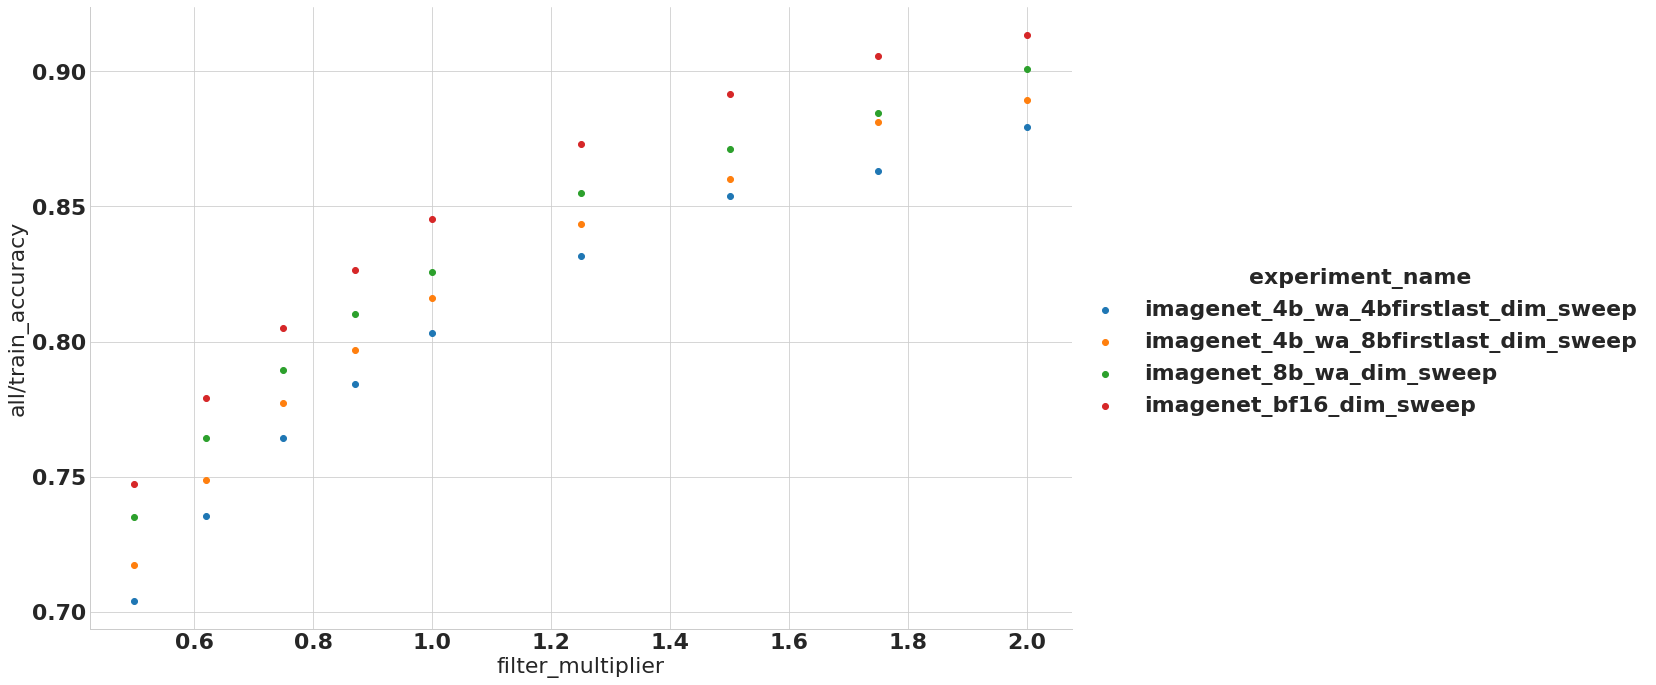

In [ ]:
#@title Example: Visualize two metric columns as a scatter plot with seaborn { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'filter_multiplier' #@param {type: 'string'}
column_for_y_axis = 'all/train_accuracy' #@param {type: 'string'}

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.scatter, column_for_x_axis, column_for_y_axis).add_legend()


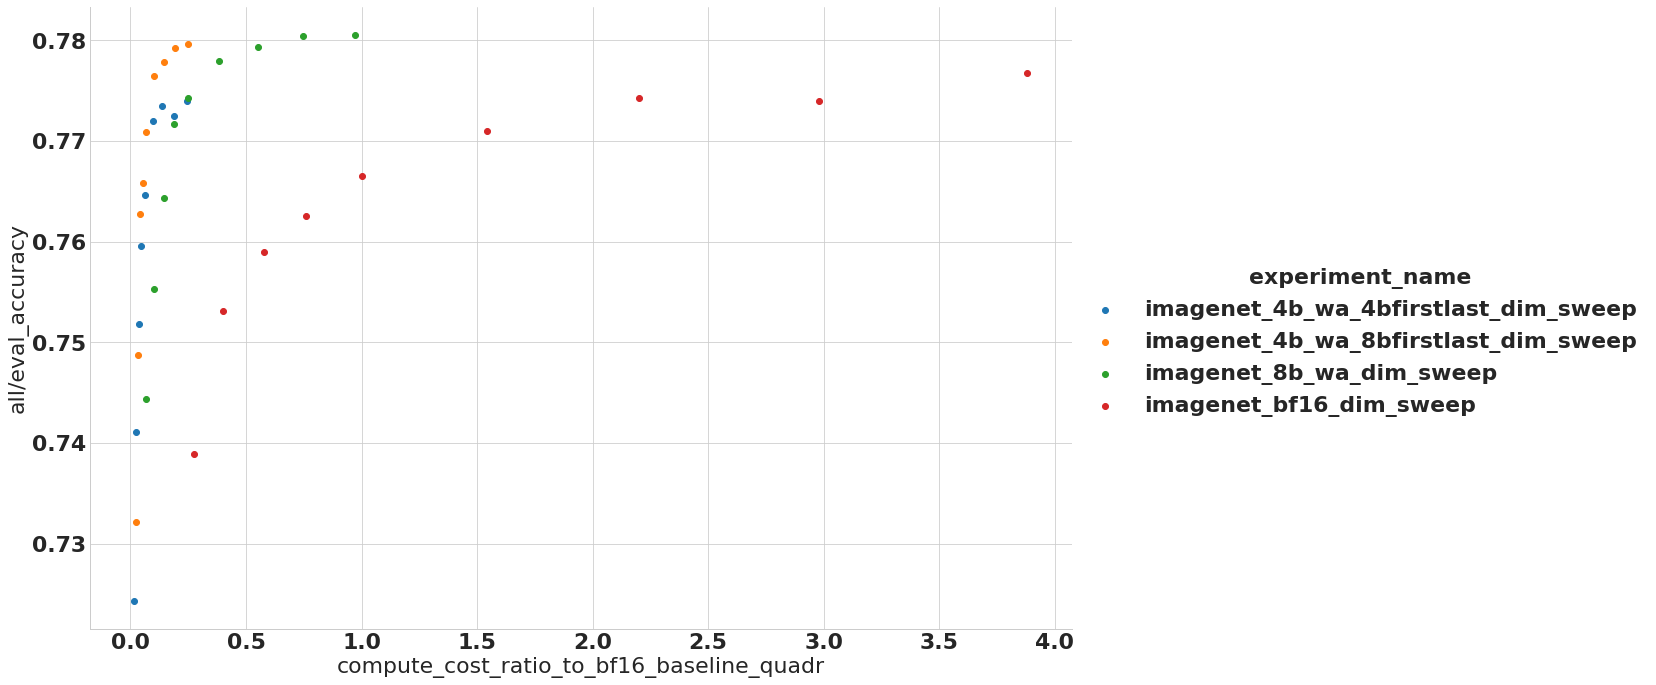

In [ ]:
#@title Example: Visualize two metric columns as a scatter plot with seaborn { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'compute_cost_ratio_to_bf16_baseline_quadr' #@param {type: 'string'}
column_for_y_axis = 'all/eval_accuracy' #@param {type: 'string'}

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.scatter, column_for_x_axis, column_for_y_axis).add_legend()


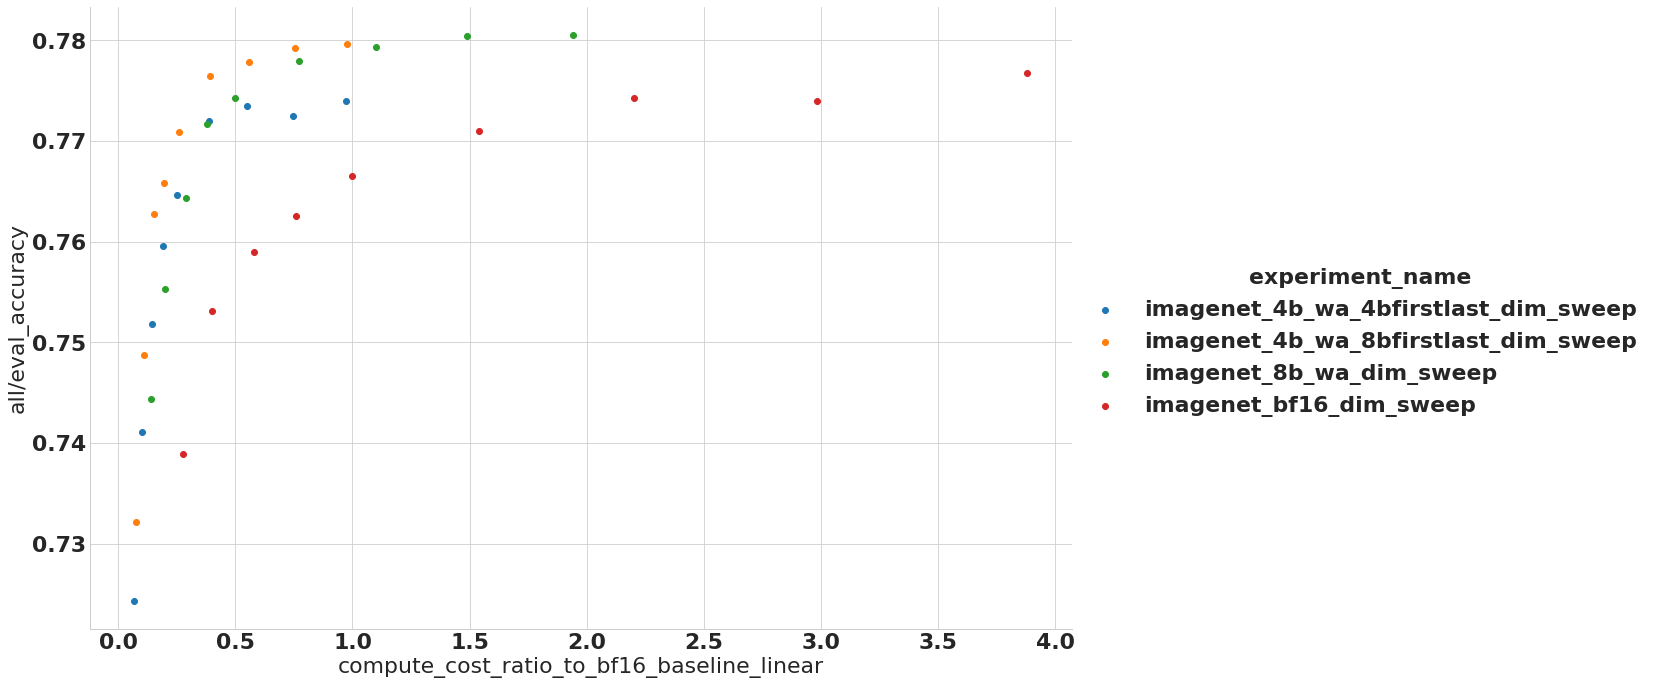

In [ ]:
#@title Example: Visualize two metric columns as a scatter plot with seaborn { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'compute_cost_ratio_to_bf16_baseline_linear' #@param {type: 'string'}
column_for_y_axis = 'all/eval_accuracy' #@param {type: 'string'}

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.scatter, column_for_x_axis, column_for_y_axis).add_legend()


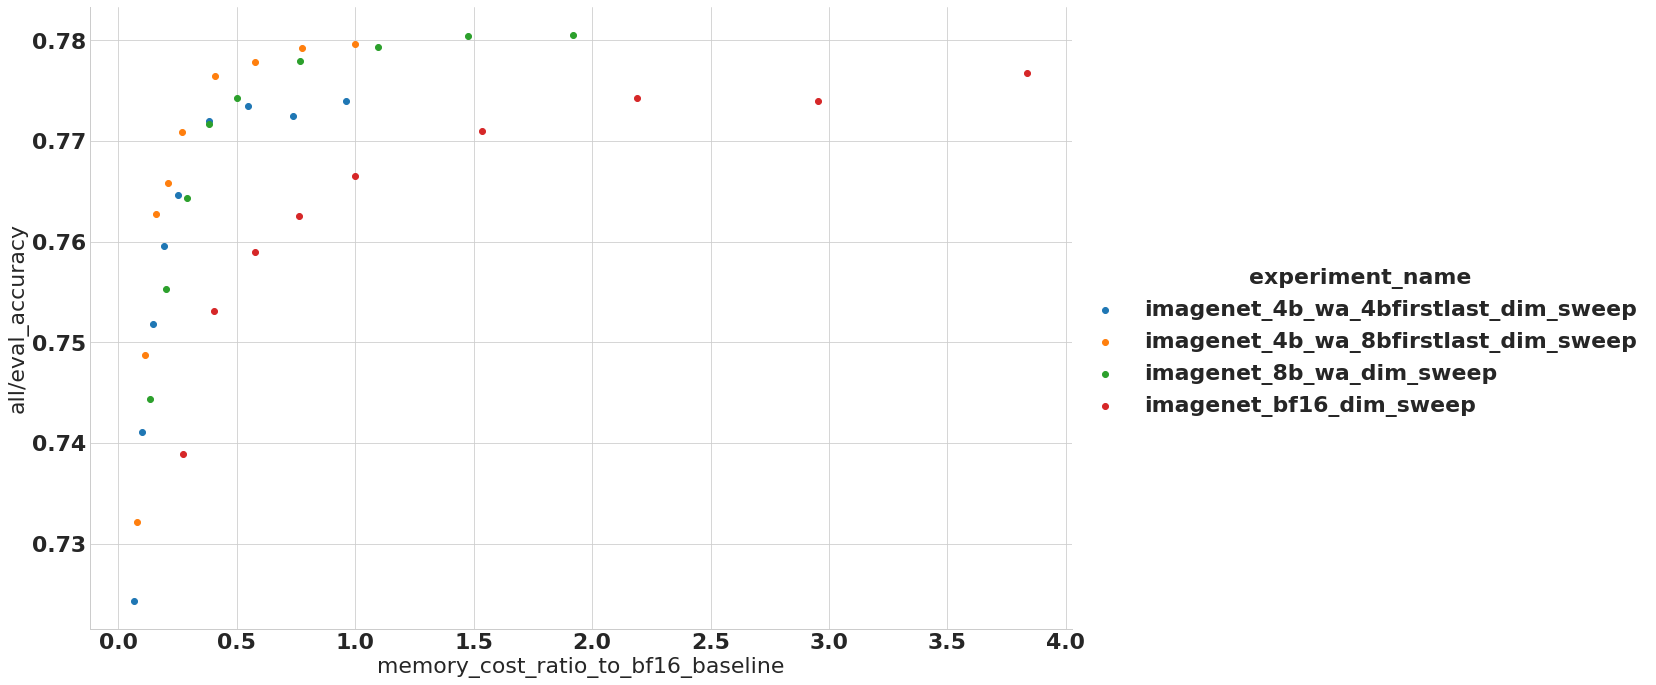

In [ ]:
#@title Example: Visualize two metric columns as a scatter plot with seaborn { display-mode: "form" }
#@markdown This could be useful if you want to understand how the model configurations differ beyond the information you have in experiment

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'memory_cost_ratio_to_bf16_baseline' #@param {type: 'string'}
column_for_y_axis = 'all/eval_accuracy' #@param {type: 'string'}

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.scatter, column_for_x_axis, column_for_y_axis).add_legend()


### Example: Create tensorboard link for all runs in your dataframe (google-internal)

In [ ]:
analysis_utils.get_tensorboard_link_for_experiments_in_df(df)

'https://tensorboard.corp.google.com/compare/0:8589197851733168309,1:3263796684541827212,2:4475110123748452209,3:8520541661940290302'

In [ ]:
agg_df = pandas_utils.group_by_with_aggregation(df, by='experiment_name', agg_column_names=['all/eval_accuracy', 'all/train_accuracy'], aggregators=('max'))

In [ ]:
agg_df

,experiment_name,all/eval_accuracy,all/train_accuracy
0,imagenet_4b_wa_4bfirstlast_dim_sweep,0.7740,0.8794
1,imagenet_4b_wa_8bfirstlast_dim_sweep,0.7796,0.8894
2,imagenet_8b_wa_dim_sweep,0.7805,0.9010
3,imagenet_bf16_dim_sweep,0.7768,0.9134


In [ ]:
df[df.filter_multiplier == 1.0][['experiment_name', 'filter_multiplier', 'all/eval_accuracy', 'all/eval_loss', 'all/train_loss']]

,experiment_name,filter_multiplier,all/eval_accuracy,all/eval_loss,all/train_loss
4,imagenet_4b_wa_4bfirstlast_dim_sweep,1.0000,0.7646,0.9170,0.8191
13,imagenet_4b_wa_8bfirstlast_dim_sweep,1.0000,0.7709,0.8891,0.7625
22,imagenet_8b_wa_dim_sweep,1.0000,0.7743,0.8808,0.7227
31,imagenet_bf16_dim_sweep,1.0000,0.7665,0.9741,0.6329


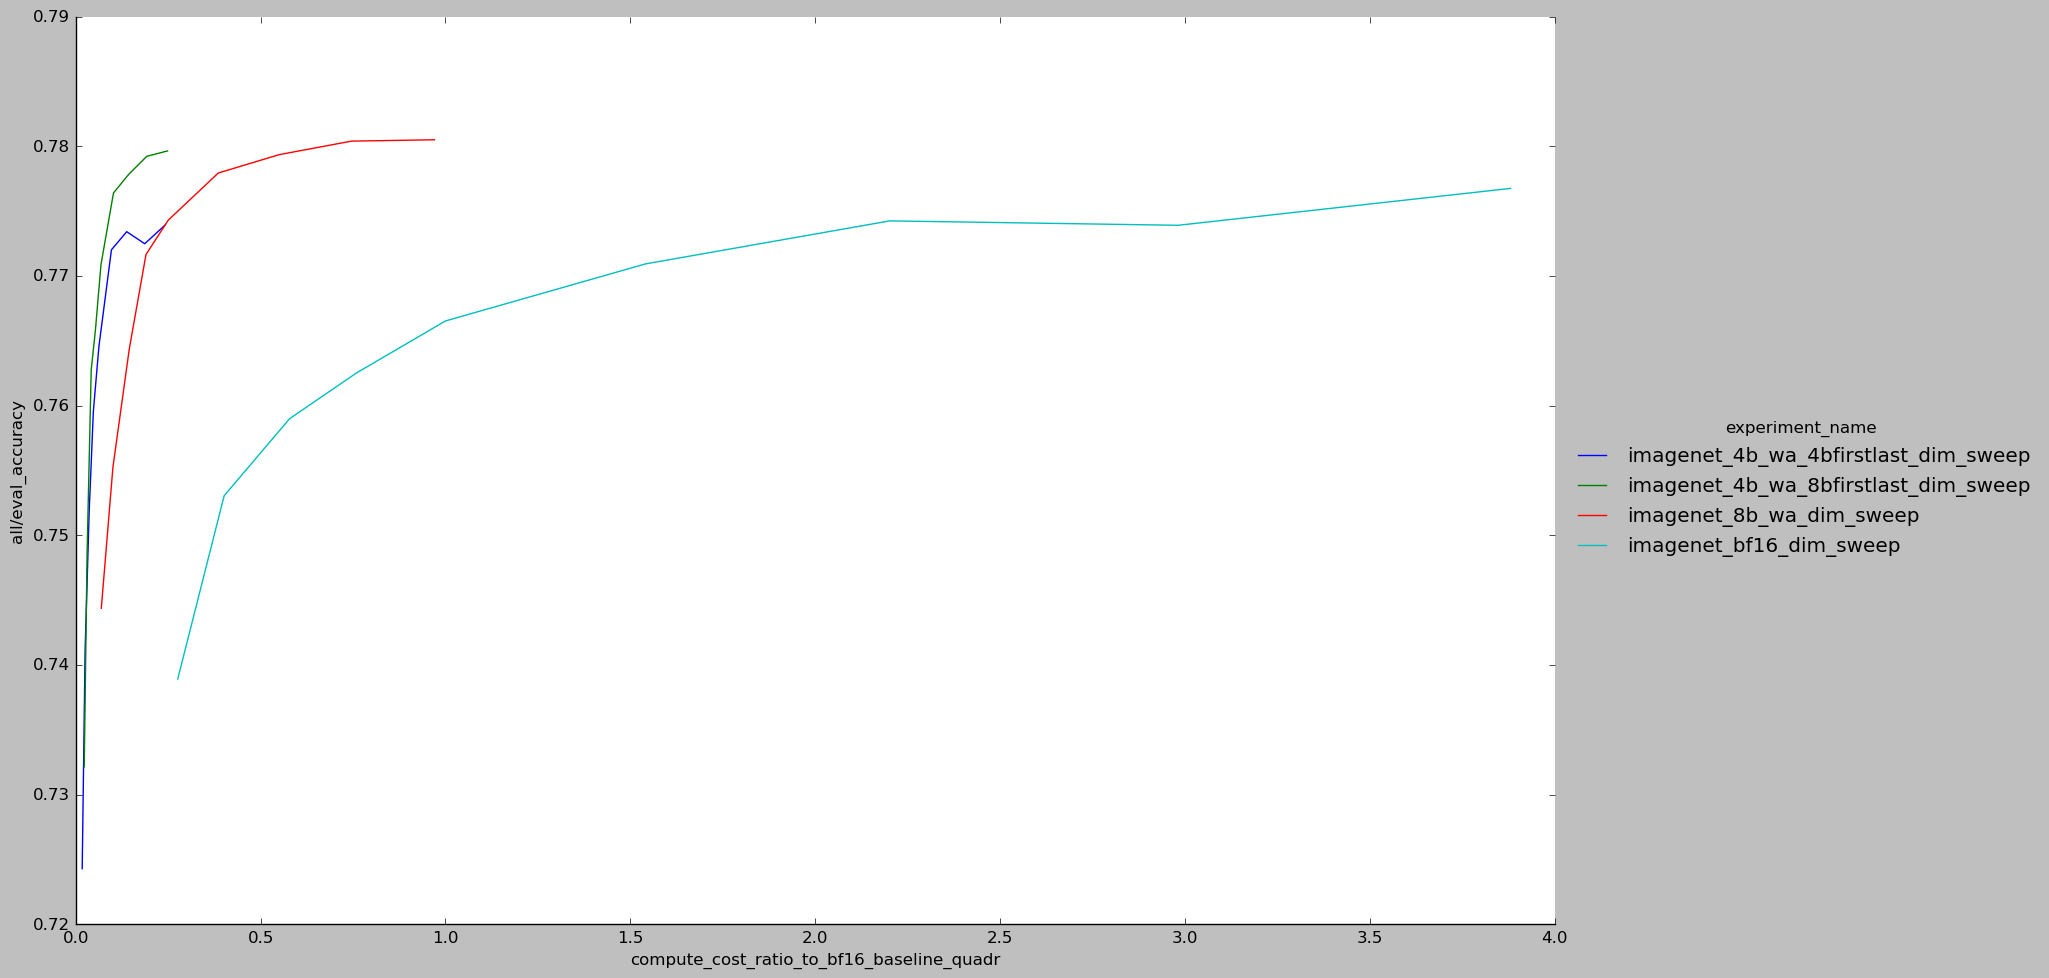

In [ ]:

#@markdown E.g. you want to know how well train and eval loss are correlated.
column_for_x_axis = 'compute_cost_ratio_to_bf16_baseline_quadr'
column_for_y_axis = 'all/eval_accuracy'

hue_order = list(df.experiment_name.unique())
# fig, ax = plt.subplots(figsize=(20,30))
fg = seaborn.FacetGrid(data=df, hue='experiment_name', hue_order=hue_order, aspect=1.61, height=10)
fg.map(plt.plot, column_for_x_axis, column_for_y_axis).add_legend()


In [ ]:
# matplotlib formatting
plt.style.use('classic')
plt.rcParams['font.size'] = '14'

In [ ]:
plot_values = {}
exp_name_to_plot_name = {
    'imagenet_4b_wa_8bfirstlast_dim_sweep': '4-bit (first/last layer in 8-bit)',
    'imagenet_4b_wa_4bfirstlast_dim_sweep': '4-bit (all layers)',
    'imagenet_8b_wa_dim_sweep': '8-bit',
    'imagenet_bf16_dim_sweep': 'bfloat16'
}
markers = ['o', 'X', 's', 'v']
colors = ['tab:purple', 'tab:blue', 'tab:orange', 'tab:green']
linestyles = ['-', ':', '--', '-.']

imagenet_4b_wa_8bfirstlast_dim_sweep
imagenet_4b_wa_4bfirstlast_dim_sweep
imagenet_8b_wa_dim_sweep
imagenet_bf16_dim_sweep


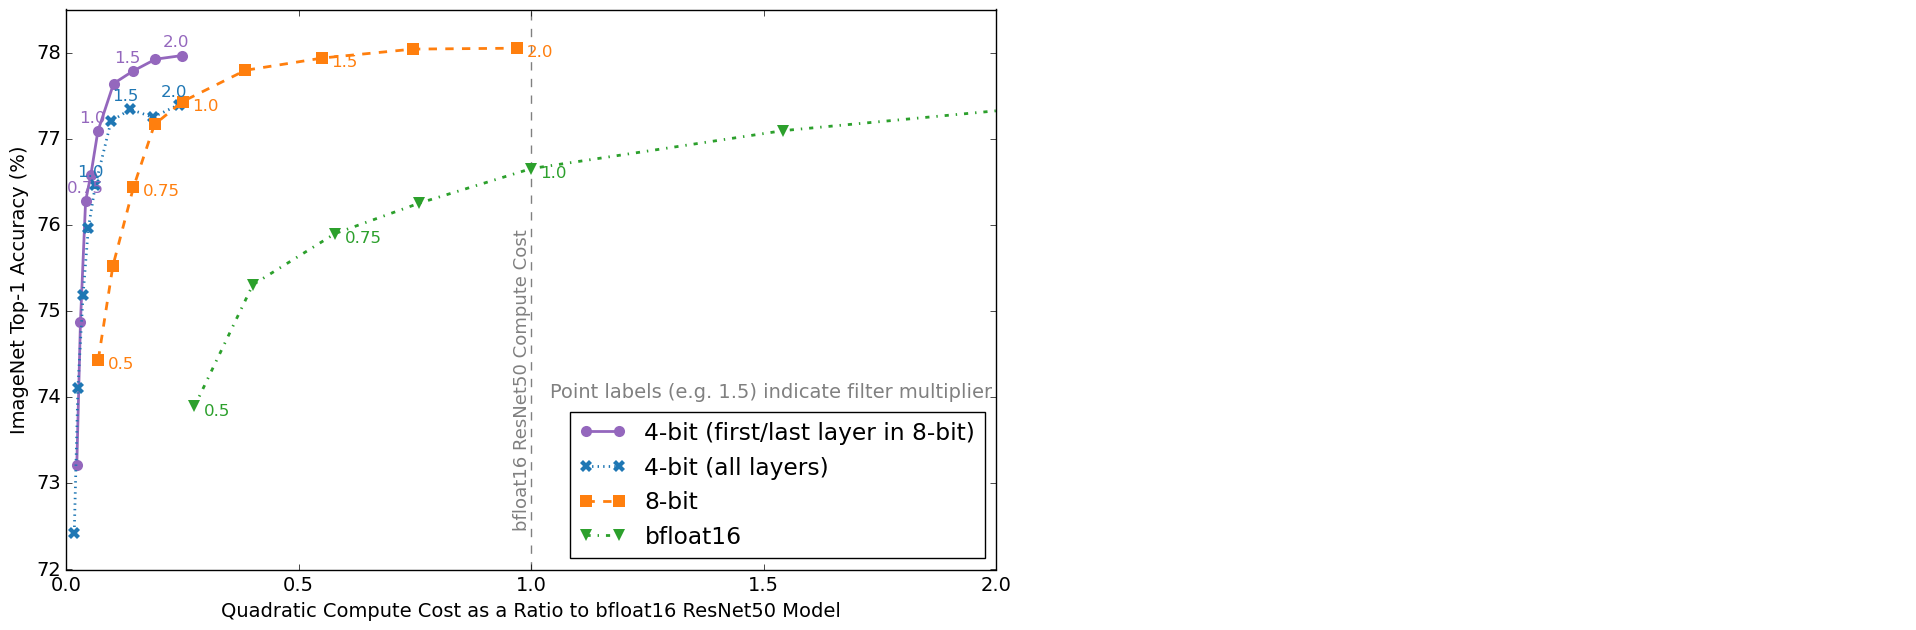

In [ ]:
column_for_x_axis = 'compute_cost_ratio_to_bf16_baseline_quadr'
column_for_y_axis = 'all/eval_accuracy'
for i, exp_name in enumerate(exp_name_to_plot_name.keys()):
  print(exp_name)
  plot_values[exp_name_to_plot_name[exp_name]] = (df.loc[df['experiment_name'] == exp_name][column_for_x_axis].values.tolist(),
                                                  onp.array(df.loc[df['experiment_name'] == exp_name][column_for_y_axis].values.tolist()) * 100,
                                                  df.loc[df['experiment_name'] == exp_name]['filter_multiplier'].values.tolist(),
                                                  markers[i],
                                                  colors[i],
                                                  linestyles[i])

fig = plt.figure(figsize=(12, 7), facecolor="white")
plt.axvline(x=1., color='gray', linestyle='--')
plt.annotate('bfloat16 ResNet50 Compute Cost', (0.96, 72.5), fontsize=13, c='gray', rotation=90)
plt.annotate('Point labels (e.g. 1.5) indicate filter multiplier', (1.04, 74), fontsize=14, c='gray')

for j, (exp, (x, y, f, m, c, ls)) in enumerate(plot_values.items()):
  plt.plot(x, y, marker=m, markeredgewidth=0.0, markersize=8.0, label=exp, c=c, ls=ls, linewidth=2.0)
  for i in range(len(x)):
    # annot = f[i]
    # if exp_name == 'bfloat16' and f[i] == 1.0:
    #   annot = 'ResNet50'
    fontsize = 12
    if (i % 2 == 0):
      if (j in {2, 3}):
        plt.annotate(str(f[i]), (x[i] + 0.02, y[i]-0.1), fontsize=fontsize, c=c)
      else:
        plt.annotate(str(f[i]), (x[i] - 0.04, y[i]+0.1), fontsize=fontsize, c=c)


plt.xlim(0, 2.0)
plt.ylim(72, 78.5)
plt.xlabel('Quadratic Compute Cost as a Ratio to bfloat16 ResNet50 Model')
plt.ylabel('ImageNet Top-1 Accuracy (%)')
plt.legend(loc='lower right')
plt.show()


imagenet_4b_wa_8bfirstlast_dim_sweep
imagenet_4b_wa_4bfirstlast_dim_sweep
imagenet_8b_wa_dim_sweep
imagenet_bf16_dim_sweep


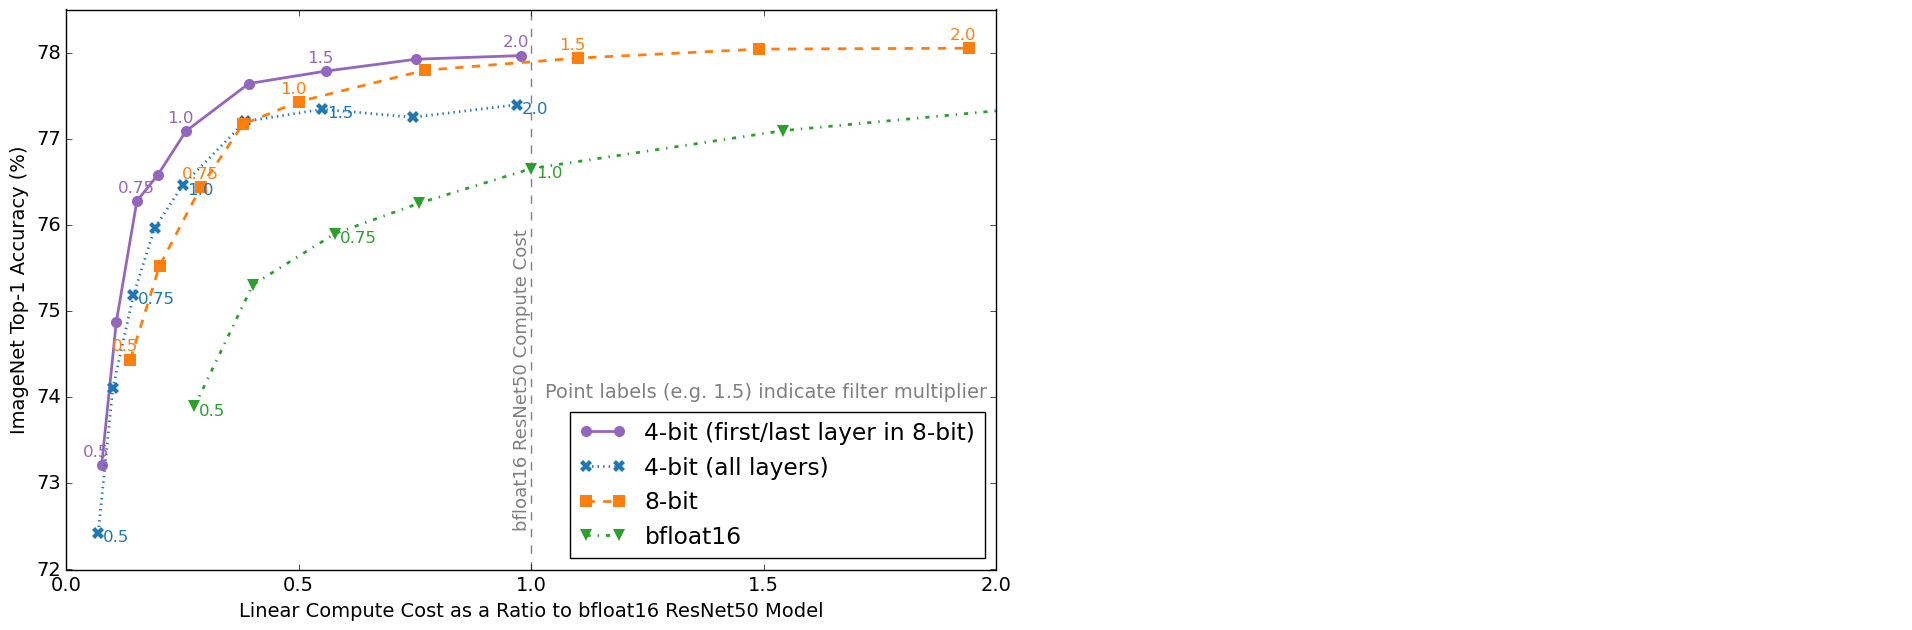

In [ ]:
column_for_x_axis = 'compute_cost_ratio_to_bf16_baseline_linear'
column_for_y_axis = 'all/eval_accuracy'
for i, exp_name in enumerate(exp_name_to_plot_name.keys()):
  print(exp_name)
  plot_values[exp_name_to_plot_name[exp_name]] = (df.loc[df['experiment_name'] == exp_name][column_for_x_axis].values.tolist(),
                                                  onp.array(df.loc[df['experiment_name'] == exp_name][column_for_y_axis].values.tolist()) * 100,
                                                  df.loc[df['experiment_name'] == exp_name]['filter_multiplier'].values.tolist(),
                                                  markers[i],
                                                  colors[i],
                                                  linestyles[i])

fig = plt.figure(figsize=(12, 7), facecolor="white")
plt.axvline(x=1., color='gray', linestyle='--')
plt.annotate('bfloat16 ResNet50 Compute Cost', (0.96, 72.5), fontsize=13, c='gray', rotation=90)
plt.annotate('Point labels (e.g. 1.5) indicate filter multiplier', (1.03, 74), fontsize=14, c='gray')

for j, (exp, (x, y, f, m, c, ls)) in enumerate(plot_values.items()):
  # plt.plot(x, y, marker=m, markeredgewidth=0.0, label=exp, c=c, ls=ls)
  plt.plot(x, y, marker=m, markeredgewidth=0.0, markersize=8.0, label=exp, c=c, ls=ls, linewidth=2.0)
  for i in range(len(x)):
    fontsize = 12
    if (i % 2 == 0):
      if (j in {1, 3}):
        plt.annotate(str(f[i]), (x[i] + 0.01, y[i]-0.1), fontsize=fontsize, c=c)
      else:
        plt.annotate(str(f[i]), (x[i] - 0.04, y[i]+0.1), fontsize=fontsize, c=c)
    # if (i % 2 == 0):
    #   if (j in {0, 3}):
    #     plt.annotate(str(f[i]), (x[i] + 0.01, y[i]-0.1), fontsize=8, c=c)
    #   else:
    #     plt.annotate(str(f[i]), (x[i] - 0.05, y[i]+0.1), fontsize=8, c=c)


plt.xlim(0, 2.0)
plt.ylim(72, 78.5)

plt.xlabel('Linear Compute Cost as a Ratio to bfloat16 ResNet50 Model')
plt.ylabel('ImageNet Top-1 Accuracy (%)')
plt.legend(loc='lower right')
plt.show()

imagenet_4b_wa_8bfirstlast_dim_sweep
imagenet_4b_wa_4bfirstlast_dim_sweep
imagenet_8b_wa_dim_sweep
imagenet_bf16_dim_sweep


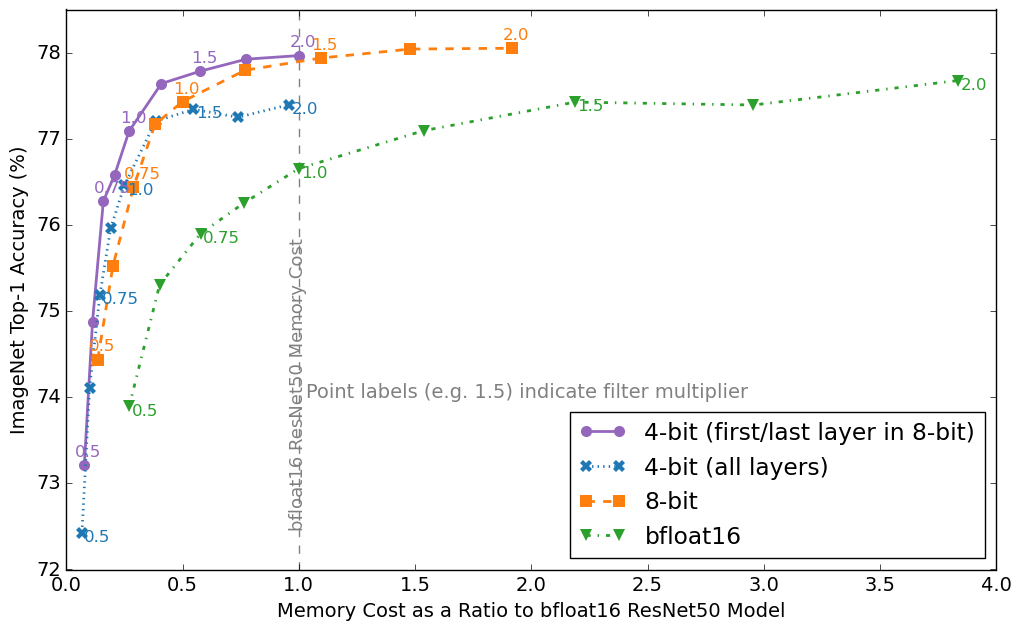

In [ ]:
column_for_x_axis = 'memory_cost_ratio_to_bf16_baseline'
column_for_y_axis = 'all/eval_accuracy'
for i, exp_name in enumerate(exp_name_to_plot_name.keys()):
  print(exp_name)
  plot_values[exp_name_to_plot_name[exp_name]] = (df.loc[df['experiment_name'] == exp_name][column_for_x_axis].values.tolist(),
                                                  onp.array(df.loc[df['experiment_name'] == exp_name][column_for_y_axis].values.tolist()) * 100,
                                                  df.loc[df['experiment_name'] == exp_name]['filter_multiplier'].values.tolist(),
                                                  markers[i],
                                                  colors[i],
                                                  linestyles[i])

fig = plt.figure(figsize=(12, 7), facecolor="white")
plt.axvline(x=1., color='gray', linestyle='--')
plt.annotate('bfloat16 ResNet50 Memory Cost', (0.96, 72.5), fontsize=13, c='gray', rotation=90)
plt.annotate('Point labels (e.g. 1.5) indicate filter multiplier', (1.03, 74), fontsize=14, c='gray')
for j, (exp, (x, y, f, m, c, ls)) in enumerate(plot_values.items()):
  plt.plot(x, y, marker=m, markeredgewidth=0.0, markersize=8.0, label=exp, c=c, ls=ls, linewidth=2.0)
  fontsize = 12
  for i in range(len(x)):
    if (i % 2 == 0):
      if (j in {1, 3}):
        plt.annotate(str(f[i]), (x[i] + 0.01, y[i]-0.1), fontsize=fontsize, c=c)
      else:
        plt.annotate(str(f[i]), (x[i] - 0.04, y[i]+0.1), fontsize=fontsize, c=c)
    # if (i % 2 == 0):
    #   if (j in {0, 3}):
    #     plt.annotate(str(f[i]), (x[i] + 0.01, y[i]-0.1), fontsize=8, c=c)
    #   else:
    #     plt.annotate(str(f[i]), (x[i] - 0.05, y[i]+0.1), fontsize=8, c=c)

plt.xlim(0, 4.0)
plt.ylim(72, 78.5)

plt.xlabel('Memory Cost as a Ratio to bfloat16 ResNet50 Model')
plt.ylabel('ImageNet Top-1 Accuracy (%)')
plt.legend(loc='lower right')
plt.show()

imagenet_4b_wa_8bfirstlast_dim_sweep
imagenet_4b_wa_4bfirstlast_dim_sweep
imagenet_8b_wa_dim_sweep
imagenet_bf16_dim_sweep


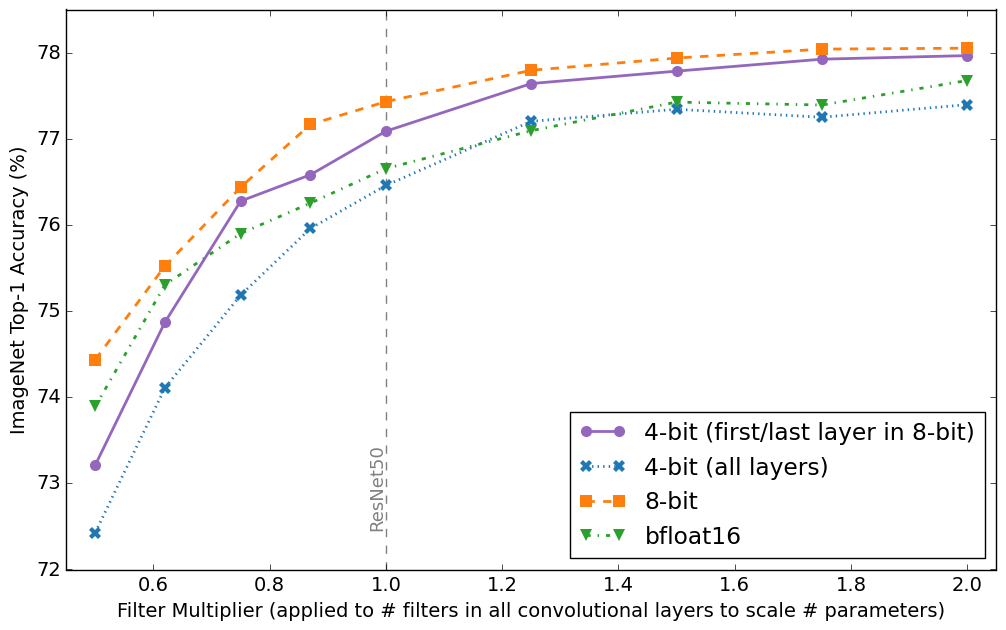

In [ ]:
column_for_x_axis = 'filter_multiplier'
column_for_y_axis = 'all/eval_accuracy'
for i, exp_name in enumerate(exp_name_to_plot_name.keys()):
  print(exp_name)
  plot_values[exp_name_to_plot_name[exp_name]] = (df.loc[df['experiment_name'] == exp_name][column_for_x_axis].values.tolist(),
                                                  onp.array(df.loc[df['experiment_name'] == exp_name][column_for_y_axis].values.tolist()) * 100,
                                                  df.loc[df['experiment_name'] == exp_name]['filter_multiplier'].values.tolist(),
                                                  markers[i],
                                                  colors[i],
                                                  linestyles[i])

fig = plt.figure(figsize=(12, 7), facecolor="white")
plt.axvline(x=1., color='gray', linestyle='--')
plt.annotate('ResNet50', (0.97, 72.5), fontsize=13, c='gray', rotation=90)
for j, (exp, (x, y, f, m, c, ls)) in enumerate(plot_values.items()):
  plt.plot(x, y, marker=m, markeredgewidth=0.0, markersize=8.0, label=exp, c=c, ls=ls, linewidth=2.0)

plt.xlim(0.45, 2.05)
plt.ylim(72, 78.5)

plt.xlabel('Filter Multiplier (applied to # filters in all convolutional layers to scale # parameters)')
plt.ylabel('ImageNet Top-1 Accuracy (%)')
plt.legend(loc='lower right')
plt.show()

imagenet_bf16_dim_sweep


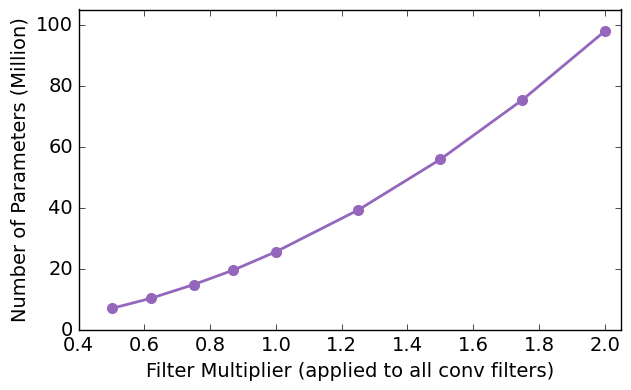

In [ ]:

column_for_x_axis = 'filter_multiplier'
column_for_y_axis = 'memory_cost'
plot_values = {}
for i, exp_name in enumerate(['imagenet_bf16_dim_sweep']):
  print(exp_name)
  plot_values[exp_name_to_plot_name[exp_name]] = (df.loc[df['experiment_name'] == exp_name][column_for_x_axis].values.tolist(),
                                                  onp.array(df.loc[df['experiment_name'] == exp_name][column_for_y_axis].values.tolist()),
                                                  df.loc[df['experiment_name'] == exp_name]['filter_multiplier'].values.tolist(),
                                                  markers[i],
                                                  colors[i],
                                                  linestyles[i])

fig = plt.figure(figsize=(7, 4), facecolor="white")

for j, (exp, (x, y, f, m, c, ls)) in enumerate(plot_values.items()):
  plt.plot(x, y/16/1e6, marker=m, markeredgewidth=0.0, markersize=8.0, label=exp, c=c, ls=ls, linewidth=2.0)

plt.xlim(0.4, 2.05)
plt.ylim(0., 1.05e2)

plt.xlabel('Filter Multiplier (applied to all conv filters)')
plt.ylabel('Number of Parameters (Million)')
plt.show()

In [ ]:
plt_values